# Importing necessary libraries

In [40]:
# Working directory
import os

# Processing data
import pandas as pd
import numpy as np
import datetime

# Linear regression model
import statsmodels.api as sm

# t test
from scipy.stats import t

# Plotting
import matplotlib.pyplot as plt

# 1. Event definition

#### We are conducting an analysis to assess the impact of a significant event on stock market returns.  The event of interest is the election of Donald J. Trump as the 47th President of the United States of America on November 6, 2024. We choose a 11-day event window, comprising 5 trading days before the event day, the event day, and 5 trading days after the event day.


In [41]:
# Defining the event window 
event_date = '2001-09-18'
event_start = -4
event_end = 5

# 2. Selection criteria

#### Our study specifically focuses on Tesla, Inc., a company of particular interest due to its CEO, Elon Musk, who has publicly expressed his support for Donald Trump. 

In [42]:
# Defining the stock
security_ticker = 'DDT'

# 3. Normal and abnormal returns

#### We use the market model to estimate normal returns, using the S&P 500 index as the market portfolio.

In [43]:
# Defining the market portfolio
market_ticker = 'FTSE'

# 4. Estimation procedure

#### We choose a 120-trading-days estimation window ending 10 days prior to the event window.

In [44]:
# Defining the estimation window
estimation_end = event_start - 5 - 1
estimation_start = estimation_end - (310 - 1)

### Importing data

In [45]:
# Importing historical data: market portfolio
data_market = pd.read_excel("stock_price_market100_converted.xlsx", skiprows=[1, 2])
data_market.head()

,Indexcd,Trddt,ExhcdOrIndexcd,IndexName,Clsidx
0,FTSE,2000-01-04,SPI,FTSE100,6665.9
1,FTSE,2000-01-05,SPI,FTSE100,6535.9
2,FTSE,2000-01-06,SPI,FTSE100,6447.2
3,FTSE,2000-01-07,SPI,FTSE100,6504.8
4,FTSE,2000-01-10,SPI,FTSE100,6607.7


In [46]:
data_market.rename(columns={'Indexcd': 'market_ticker', 'Trddt': 'trading_date', 'Clsidx': 'price'}, 
                   inplace=True)
data_market = data_market[['trading_date', 'market_ticker', 'price']]
data_market = data_market[data_market['market_ticker']==market_ticker]
data_market.head()

,trading_date,market_ticker,price
0,2000-01-04,FTSE,6665.9
1,2000-01-05,FTSE,6535.9
2,2000-01-06,FTSE,6447.2
3,2000-01-07,FTSE,6504.8
4,2000-01-10,FTSE,6607.7


In [47]:
## Calculating daily returns 
data_market['market_return'] =  data_market['price'].pct_change()
data_market = data_market[['trading_date', 'market_return']]
data_market.head()

,trading_date,market_return
0,2000-01-04,NaN
1,2000-01-05,-0.019502
2,2000-01-06,-0.013571
3,2000-01-07,0.008934
4,2000-01-10,0.015819


In [48]:
data_other_securities = pd.read_excel("stock_price_securities_other_five.xlsx", skiprows=[1])
data_other_securities.rename(columns={'Date': 'trading_date'}, inplace=True)
data_other_securities['trading_date'] = data_other_securities['trading_date'].dt.strftime('%Y-%m-%d')
data_other_securities['British Airways'] = data_other_securities['British Airways'].pct_change()
data_other_securities['Canary Wharf'] = data_other_securities['Canary Wharf'].pct_change()
data_other_securities['Dimension Data'] = data_other_securities['Dimension Data'].pct_change()
data_other_securities['Dixons'] = data_other_securities['Dixons'].pct_change()
data_other_securities['Scottish and Newcastle'] = data_other_securities['Scottish and Newcastle'].pct_change()
data_other_securities['United Utilities'] = data_other_securities['United Utilities'].pct_change()
data_other_securities.tail()
data_all = pd.merge(data_market, data_other_securities, on='trading_date', how='left')
data_all.head()


,trading_date,market_return,British Airways,Canary Wharf,Dimension Data,Dixons,Scottish and Newcastle,United Utilities
0,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-05,-0.019502,0.002462,-0.012937,NaN,NaN,0.004159,0.014516
2,2000-01-06,-0.013571,-0.000614,0.013106,NaN,NaN,0.059763,0.038951
3,2000-01-07,0.008934,-0.003071,0.001294,NaN,NaN,0.045226,0.017598
4,2000-01-10,0.015819,-0.035120,-0.001292,NaN,NaN,-0.064637,0.016541


In [49]:
data_all.rename(columns={'British Airways': 'BA_return', 'Canary Wharf': 'CW_return', 'Dimension Data': 'DD_return', 'Dixons': 'DX_return', 'Scottish and Newcastle': 'SC_return', 'United Utilities': 'UU_return'}, inplace=True)
data_all.head()

,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return
0,2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-05,-0.019502,0.002462,-0.012937,NaN,NaN,0.004159,0.014516
2,2000-01-06,-0.013571,-0.000614,0.013106,NaN,NaN,0.059763,0.038951
3,2000-01-07,0.008934,-0.003071,0.001294,NaN,NaN,0.045226,0.017598
4,2000-01-10,0.015819,-0.035120,-0.001292,NaN,NaN,-0.064637,0.016541


In [50]:
index_event_day = data_all.index[data_all['trading_date']==event_date].tolist()

In [51]:
index_event_day

[432]

In [52]:
if index_event_day:
    data_all['event_time'] = 0
    for i in range(len(data_all)):
        data_all.loc[data_all.index[i], 'event_time'] = i - index_event_day[0]
else:
    print("No trading date matches the event date.")
data_all[(data_all['event_time']>=event_start) & (data_all['event_time']<=event_end)]

,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time
428,2001-09-12,0.028677,0.000000,0.030303,-0.005348,0.005347,0.006148,0.037037,-4
429,2001-09-13,0.012597,-0.057692,-0.009804,-0.021505,0.015957,0.051935,-0.001623,-3
430,2001-09-14,-0.038009,-0.158163,-0.027723,0.000000,-0.010472,-0.038722,-0.029268,-2
431,2001-09-17,0.030111,0.066667,-0.020366,-0.027473,-0.015873,0.035247,0.026801,-1
432,2001-09-18,-0.010247,-0.011364,-0.026507,-0.039548,-0.026881,0.001946,-0.008157,0
433,2001-09-19,-0.026193,-0.063218,-0.009076,-0.076471,0.049724,-0.009709,0.047697,1
434,2001-09-20,-0.034903,-0.122699,-0.019397,-0.130573,-0.126316,-0.002941,-0.018838,2
435,2001-09-21,-0.027036,0.062937,-0.056044,-0.003663,-0.030121,-0.032448,-0.016000,3
436,2001-09-24,0.040643,0.118421,0.071013,0.044118,0.043478,0.022358,-0.020325,4
437,2001-09-25,0.010728,0.026471,-0.007065,-0.014085,0.047620,-0.010437,0.025726,5


### Estimating the market model

In [53]:
data_all_estimation = data_all[(data_all['event_time']>=estimation_start) & (data_all['event_time']<=estimation_end)]
data_all_estimation.tail()

,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time
418,2001-08-29,-0.003146,-0.026046,-0.010932,0.006466,-0.036885,-0.003781,-0.003140,-14
419,2001-08-30,-0.015671,-0.009724,-0.002403,-0.027837,-0.025532,-0.001898,-0.007874,-13
420,2001-08-31,0.002307,0.001637,-0.004335,0.006608,-0.021835,-0.009506,0.000000,-12
421,2001-09-03,-0.006155,-0.023693,0.006289,-0.019694,-0.080357,-0.021113,0.000794,-11
422,2001-09-04,0.012707,-0.005858,0.008173,0.013393,-0.019417,0.023529,0.002379,-10


In [54]:
print(len(data_all_estimation))
data_all_estimation.dropna(inplace=True)
print(len(data_all_estimation))

310
285


/var/folders/1s/plws044x63xc53g7y6vyflzh0000gn/T/ipykernel_42244/1162392699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_all_estimation.dropna(inplace=True)


In [55]:
X_estimation = data_all_estimation['market_return']
X_estimation = sm.add_constant(X_estimation)

In [56]:
R1_estimation = data_all_estimation['BA_return']
market_model1 = sm.OLS(R1_estimation, X_estimation).fit()
print(market_model1.summary())

                            OLS Regression Results                            
Dep. Variable:              BA_return   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     17.99
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           3.01e-05
Time:                        22:00:52   Log-Likelihood:                 659.92
No. Observations:                 285   AIC:                            -1316.
Df Residuals:                     283   BIC:                            -1309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0003      0.001     -0.221

In [57]:
R2_estimation = data_all_estimation['CW_return']
market_model2 = sm.OLS(R2_estimation, X_estimation).fit()
print(market_model2.summary())

                            OLS Regression Results                            
Dep. Variable:              CW_return   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     18.29
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           2.60e-05
Time:                        22:00:52   Log-Likelihood:                 760.31
No. Observations:                 285   AIC:                            -1517.
Df Residuals:                     283   BIC:                            -1509.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.077

In [58]:
R3_estimation = data_all_estimation['DD_return']
market_model3 = sm.OLS(R3_estimation, X_estimation).fit()
print(market_model3.summary())

                            OLS Regression Results                            
Dep. Variable:              DD_return   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     43.74
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.86e-10
Time:                        22:00:52   Log-Likelihood:                 449.73
No. Observations:                 285   AIC:                            -895.5
Df Residuals:                     283   BIC:                            -888.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0031      0.003     -1.058

In [59]:
R4_estimation = data_all_estimation['DX_return']
market_model4 = sm.OLS(R4_estimation, X_estimation).fit()
print(market_model4.summary())

                            OLS Regression Results                            
Dep. Variable:              DX_return   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     39.79
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           1.09e-09
Time:                        22:00:52   Log-Likelihood:                 607.74
No. Observations:                 285   AIC:                            -1211.
Df Residuals:                     283   BIC:                            -1204.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0014      0.002     -0.825

In [60]:
R5_estimation = data_all_estimation['SC_return']
market_model5 = sm.OLS(R5_estimation, X_estimation).fit()
print(market_model5.summary())

                            OLS Regression Results                            
Dep. Variable:              SC_return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1446
Date:                Thu, 05 Dec 2024   Prob (F-statistic):              0.704
Time:                        22:00:52   Log-Likelihood:                 738.16
No. Observations:                 285   AIC:                            -1472.
Df Residuals:                     283   BIC:                            -1465.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.293

In [61]:
R6_estimation = data_all_estimation['UU_return']
market_model6 = sm.OLS(R6_estimation, X_estimation).fit()
print(market_model6.summary())

                            OLS Regression Results                            
Dep. Variable:              UU_return   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     4.810
Date:                Thu, 05 Dec 2024   Prob (F-statistic):             0.0291
Time:                        22:00:52   Log-Likelihood:                 773.12
No. Observations:                 285   AIC:                            -1542.
Df Residuals:                     283   BIC:                            -1535.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.665e-05      0.001      0.070

# 5. Testing procedure

### Calculating abnormal returns

In [62]:
data_all_event = data_all[(data_all['event_time']>=event_start) & (data_all['event_time']<=event_end)]
data_all_event = data_all_event.reset_index()
data_all_event

,index,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time
0,428,2001-09-12,0.028677,0.000000,0.030303,-0.005348,0.005347,0.006148,0.037037,-4
1,429,2001-09-13,0.012597,-0.057692,-0.009804,-0.021505,0.015957,0.051935,-0.001623,-3
2,430,2001-09-14,-0.038009,-0.158163,-0.027723,0.000000,-0.010472,-0.038722,-0.029268,-2
3,431,2001-09-17,0.030111,0.066667,-0.020366,-0.027473,-0.015873,0.035247,0.026801,-1
4,432,2001-09-18,-0.010247,-0.011364,-0.026507,-0.039548,-0.026881,0.001946,-0.008157,0
5,433,2001-09-19,-0.026193,-0.063218,-0.009076,-0.076471,0.049724,-0.009709,0.047697,1
6,434,2001-09-20,-0.034903,-0.122699,-0.019397,-0.130573,-0.126316,-0.002941,-0.018838,2
7,435,2001-09-21,-0.027036,0.062937,-0.056044,-0.003663,-0.030121,-0.032448,-0.016000,3
8,436,2001-09-24,0.040643,0.118421,0.071013,0.044118,0.043478,0.022358,-0.020325,4
9,437,2001-09-25,0.010728,0.026471,-0.007065,-0.014085,0.047620,-0.010437,0.025726,5


In [63]:
## Calculating normal returns 
X_event = data_all_event['market_return']
X_event = sm.add_constant(X_event)
data_all_event['normal_return_BA'] = market_model1.predict(X_event)
data_all_event['normal_return_CW'] = market_model2.predict(X_event)
data_all_event['normal_return_DD'] = market_model3.predict(X_event)
data_all_event['normal_return_DX'] = market_model4.predict(X_event)
data_all_event['normal_return_SC'] = market_model5.predict(X_event)
data_all_event['normal_return_UU'] = market_model6.predict(X_event)

### Calculating average abnormal returns

In [64]:
data_all_event['abnormal_return_BA'] = data_all_event['BA_return'] - data_all_event['normal_return_BA']
data_all_event['abnormal_return_CW'] = data_all_event['CW_return'] - data_all_event['normal_return_CW']
data_all_event['abnormal_return_DD'] = data_all_event['DD_return'] - data_all_event['normal_return_DD']
data_all_event['abnormal_return_DX'] = data_all_event['DX_return'] - data_all_event['normal_return_DX']
data_all_event['abnormal_return_SC'] = data_all_event['SC_return'] - data_all_event['normal_return_SC']
data_all_event['abnormal_return_UU'] = data_all_event['UU_return'] - data_all_event['normal_return_UU']

In [65]:
# Get average abnormal returns
data_all_event['cumulative_abnormal_return'] = data_all_event[['abnormal_return_BA', 'abnormal_return_CW', 'abnormal_return_DD', 'abnormal_return_DX', 'abnormal_return_SC', 'abnormal_return_UU']].mean(axis=1)

In [66]:
data_all_event.head()

,index,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time,...,normal_return_DX,normal_return_SC,normal_return_UU,abnormal_return_BA,abnormal_return_CW,abnormal_return_DD,abnormal_return_DX,abnormal_return_SC,abnormal_return_UU,cumulative_abnormal_return
0,428,2001-09-12,0.028677,0.000000,0.030303,-0.005348,0.005347,0.006148,0.037037,-4,...,0.026635,0.001387,0.005524,-0.015387,0.018095,-0.053391,-0.021288,0.004761,0.031513,-0.005950
1,429,2001-09-13,0.012597,-0.057692,-0.009804,-0.021505,0.015957,0.051935,-0.001623,-3,...,0.010910,0.000787,0.002464,-0.064275,-0.015771,-0.040846,0.005047,0.051148,-0.004088,-0.011464
2,430,2001-09-14,-0.038009,-0.158163,-0.027723,0.000000,-0.010472,-0.038722,-0.029268,-2,...,-0.038577,-0.001101,-0.007167,-0.137038,-0.014046,0.070993,0.028105,-0.037621,-0.022101,-0.018618
3,431,2001-09-17,0.030111,0.066667,-0.020366,-0.027473,-0.015873,0.035247,0.026801,-1,...,0.028038,0.001440,0.005797,0.050494,-0.033132,-0.078076,-0.043911,0.033806,0.021003,-0.008302
4,432,2001-09-18,-0.010247,-0.011364,-0.026507,-0.039548,-0.026881,0.001946,-0.008157,0,...,-0.011429,-0.000065,-0.001884,-0.005439,-0.023607,-0.018111,-0.015452,0.002011,-0.006273,-0.011145


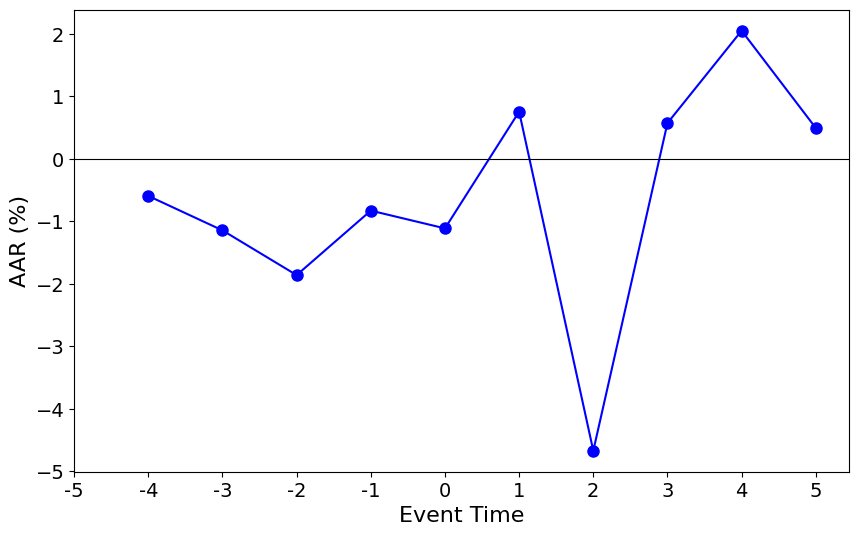

In [67]:
# Plotting the cumulative abnormal returns
plt.figure(figsize=(10, 6)) 
plt.plot(data_all_event['event_time'], 100*data_all_event['cumulative_abnormal_return'], 
         marker='o', linestyle='-', color='b', markersize=8) 
plt.axhline(0, color='black', linewidth=0.8)

## Customizing the plot
plt.xlabel('Event Time', fontsize=16)
plt.ylabel('AAR (%)', fontsize=16)
ticks = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
plt.xticks(ticks, ticks)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Showing the plot
plt.show()

### Significane of ARs and AARs

In [68]:
# Calculating the sample standard errors of ARs
## Equations (4.4) and (4.5)
L1 = data_all_estimation.shape[0]
e_hat_estimation = data_all_event["cumulative_abnormal_return"]
sigma2_hat = np.sum(np.square(e_hat_estimation)) / (L1 - 2)
np.sqrt(sigma2_hat)

np.float64(0.0034775086693843954)

In [69]:
data_all_estimation.head()

,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time
138,2000-07-20,0.000557,-0.025773,-0.003492,0.012433,0.012316,0.022863,0.008277,-294
139,2000-07-21,-0.014005,0.002646,0.011682,0.041228,0.004866,-0.028183,-0.004478,-293
140,2000-07-24,0.000455,-0.017150,0.063510,-0.010952,-0.009685,0.000000,-0.002999,-292
141,2000-07-25,0.001473,-0.020134,0.007601,-0.005963,-0.007335,0.000000,-0.007519,-291
142,2000-07-26,-0.000563,0.030137,0.005388,-0.005998,-0.004926,-0.004000,0.004545,-290


In [70]:
## Equation (5.3)
L2 = data_all_event.shape[0]
V_hat = sigma2_hat*np.eye(L2) + sigma2_hat*X_event@np.linalg.inv(X_estimation.T@X_estimation)@X_event.T.values
V_hat

,0,1,2,3,4,5,6,7,8,9
0,1.243581e-05,1.777136e-07,-3.416611e-07,3.574644e-07,-5.674025e-08,-2.203902e-07,-3.097832e-07,-2.290455e-07,4.655561e-07,1.585360e-07
1,1.777136e-07,1.219644e-05,-1.305916e-07,1.843455e-07,-2.242510e-09,-7.596236e-08,-1.162315e-07,-7.986133e-08,2.330378e-07,9.473360e-08
2,-3.416611e-07,-1.305916e-07,1.262675e-05,-3.604904e-07,1.692714e-07,3.785773e-07,4.929097e-07,3.896473e-07,-4.987381e-07,-1.060638e-07
3,3.574644e-07,1.843455e-07,-3.604904e-07,1.246597e-05,-6.160192e-08,-2.332744e-07,-3.270497e-07,-2.423540e-07,4.862988e-07,1.642277e-07
4,-5.674025e-08,-2.242510e-09,1.692714e-07,-6.160192e-08,1.216825e-05,1.292239e-07,1.587444e-07,1.320822e-07,-9.729723e-08,4.090538e-09
5,-2.203902e-07,-7.596236e-08,3.785773e-07,-2.332744e-07,1.292239e-07,1.236551e-05,3.506788e-07,2.800198e-07,-3.278727e-07,-5.917876e-08
6,-3.097832e-07,-1.162315e-07,4.929097e-07,-3.270497e-07,1.587444e-07,3.506788e-07,1.254859e-05,3.608301e-07,-4.538235e-07,-9.373933e-08
7,-2.290455e-07,-7.986133e-08,3.896473e-07,-2.423540e-07,1.320822e-07,2.800198e-07,3.608301e-07,1.238091e-05,-3.400676e-07,-6.252501e-08
8,4.655561e-07,2.330378e-07,-4.987381e-07,4.862988e-07,-9.729723e-08,-3.278727e-07,-4.538235e-07,-3.400676e-07,1.273166e-05,2.060175e-07
9,1.585360e-07,9.473360e-08,-1.060638e-07,1.642277e-07,4.090538e-09,-5.917876e-08,-9.373933e-08,-6.252501e-08,2.060175e-07,1.218039e-05


In [71]:
## Sample standard errors of ARs
data_all_event['s.e._abnormal_return'] = np.sqrt(np.diag(V_hat))

In [72]:
# Calculating the sample standard errors of CARs
data_all_event['s.e._cumulative_abnormal_return'] = np.sqrt(np.cumsum(np.diag(V_hat)))

In [73]:
# t statistics and p values: Testing the significance of CARs
data_all_event['t_cumulative_abnormal_return'] = data_all_event['cumulative_abnormal_return'] / data_all_event['s.e._cumulative_abnormal_return']
data_all_event['p_cumulative_abnormal_return'] = 2*t.sf(np.abs(data_all_event['t_cumulative_abnormal_return']), L1 - 2)

In [74]:
# Confidence intervals: CARs
data_all_event['upper_cumulative_abnormal_return'] = data_all_event['cumulative_abnormal_return'] + t.ppf(1 - 0.1/2, L1 - 2)*data_all_event['s.e._cumulative_abnormal_return']
data_all_event['lower_cumulative_abnormal_return'] = data_all_event['cumulative_abnormal_return'] - t.ppf(1 - 0.1/2, L1 - 2)*data_all_event['s.e._cumulative_abnormal_return']

In [75]:
data_all_event.head()

,index,trading_date,market_return,BA_return,CW_return,DD_return,DX_return,SC_return,UU_return,event_time,...,abnormal_return_DX,abnormal_return_SC,abnormal_return_UU,cumulative_abnormal_return,s.e._abnormal_return,s.e._cumulative_abnormal_return,t_cumulative_abnormal_return,p_cumulative_abnormal_return,upper_cumulative_abnormal_return,lower_cumulative_abnormal_return
0,428,2001-09-12,0.028677,0.000000,0.030303,-0.005348,0.005347,0.006148,0.037037,-4,...,-0.021288,0.004761,0.031513,-0.005950,0.003526,0.003526,-1.687128,0.092681,-0.000130,-0.011769
1,429,2001-09-13,0.012597,-0.057692,-0.009804,-0.021505,0.015957,0.051935,-0.001623,-3,...,0.005047,0.051148,-0.004088,-0.011464,0.003492,0.004963,-2.309861,0.021616,-0.003274,-0.019654
2,430,2001-09-14,-0.038009,-0.158163,-0.027723,0.000000,-0.010472,-0.038722,-0.029268,-2,...,0.028105,-0.037621,-0.022101,-0.018618,0.003553,0.006104,-3.050138,0.002504,-0.008545,-0.028691
3,431,2001-09-17,0.030111,0.066667,-0.020366,-0.027473,-0.015873,0.035247,0.026801,-1,...,-0.043911,0.033806,0.021003,-0.008302,0.003531,0.007052,-1.177380,0.240033,0.003335,-0.019939
4,432,2001-09-18,-0.010247,-0.011364,-0.026507,-0.039548,-0.026881,0.001946,-0.008157,0,...,-0.015452,0.002011,-0.006273,-0.011145,0.003488,0.007867,-1.416637,0.157689,0.001838,-0.024128


In [76]:
data_all_event.rename(columns={'cumulative_abnormal_return': 'CAR',
                               's.e._abnormal_return': 's.e._AR',
                               's.e._cumulative_abnormal_return': 's.e._CAR',
                               't_cumulative_abnormal_return': 't_CAR',
                               'p_cumulative_abnormal_return': 'p_CAR',
                               'upper_cumulative_abnormal_return': 'upper_CAR',
                               'lower_cumulative_abnormal_return': 'lower_CAR'}, inplace=True)
data_all_event[['event_time', 's.e._AR', 'CAR', 's.e._CAR', 't_CAR', 'p_CAR', 'upper_CAR', 'lower_CAR']]

,event_time,s.e._AR,CAR,s.e._CAR,t_CAR,p_CAR,upper_CAR,lower_CAR
0,-4,0.003526,-0.005950,0.003526,-1.687128,9.268053e-02,-0.000130,-0.011769
1,-3,0.003492,-0.011464,0.004963,-2.309861,2.161552e-02,-0.003274,-0.019654
2,-2,0.003553,-0.018618,0.006104,-3.050138,2.504123e-03,-0.008545,-0.028691
3,-1,0.003531,-0.008302,0.007052,-1.177380,2.400330e-01,0.003335,-0.019939
4,0,0.003488,-0.011145,0.007867,-1.416637,1.576888e-01,0.001838,-0.024128
5,1,0.003516,0.007532,0.008617,0.874083,3.828144e-01,0.021753,-0.006689
6,2,0.003542,-0.046720,0.009317,-5.014468,9.398142e-07,-0.031345,-0.062096
7,3,0.003519,0.005703,0.009959,0.572628,5.673513e-01,0.022138,-0.010732
8,4,0.003568,0.020482,0.010579,1.936089,5.385242e-02,0.037941,0.003024
9,5,0.003490,0.004919,0.011140,0.441568,6.591393e-01,0.023303,-0.013465


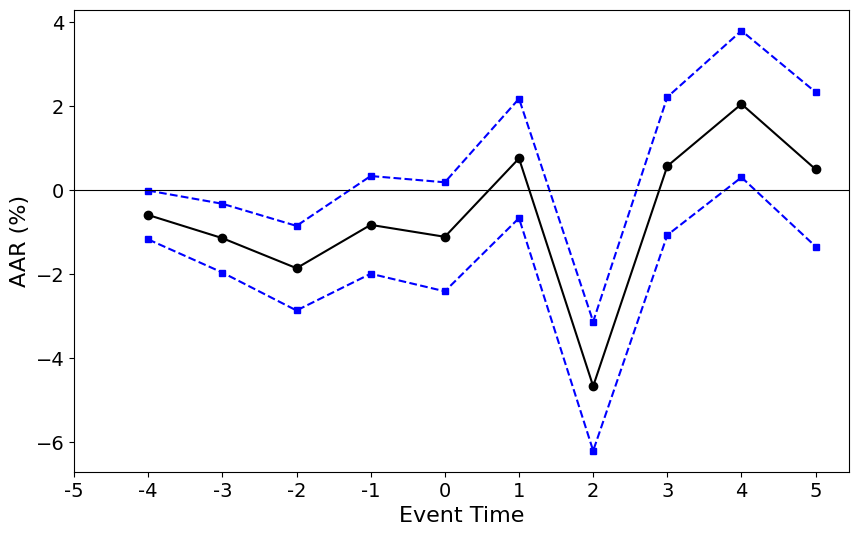

In [77]:
# Plotting the cumulative abnormal returns
plt.figure(figsize=(10, 6)) 
plt.plot(data_all_event['event_time'], 100*data_all_event['CAR'], 
         marker='o', linestyle='-', color='black', markersize=6) 
plt.plot(data_all_event['event_time'], 100*data_all_event['upper_CAR'], 
         marker='s', linestyle='--', color='blue', markersize=4) 
plt.plot(data_all_event['event_time'], 100*data_all_event['lower_CAR'], 
         marker='s', linestyle='--', color='blue', markersize=4) 
plt.axhline(0, color='black', linewidth=0.8)

## Customizing the plot
plt.xlabel('Event Time', fontsize=16)
plt.ylabel('AAR (%)', fontsize=16)
ticks = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
plt.xticks(ticks, ticks)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Showing the plot
plt.show()

### Replicating the results provided by the 'eventstudy' library

In [78]:
# Sample standard errors of ARs
np.sqrt(np.var(e_hat_estimation))

np.float64(0.017373310313063942)

In [79]:
# Sample standard errors of CARs
np.sqrt(np.var(e_hat_estimation)*range(1,12))

array([0.01737331, 0.02456957, 0.03009146, 0.03474662, 0.0388479 ,
       0.04255575, 0.04596546, 0.04913914, 0.05211993, 0.05493923,
       0.05762075])

In [80]:
# t statistics
t_statistic = np.array(data_all_event[['CAR']].T) / np.array(np.sqrt(np.var(e_hat_estimation)*range(1,12))).T
t_statistic

ValueError: operands could not be broadcast together with shapes (1,10) (11,) 

In [45]:
# p values
2*t.sf(np.abs(t_statistic), data_all_estimation.shape[0] - 2)

array([[0.0473137 , 0.31097136, 0.96802965, 0.80263508, 0.97731354,
        0.91954751, 0.95905094, 0.95908065, 0.80878165, 0.94958988,
        0.723564  ]])